### League of Legends - Predicting win based on first 10 minutes of the game

##### 🔧 Import libraries, set up 🔧

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('darkgrid')

##### ⬆️ Load and set up the data set ⬆️

In [199]:
df = pd.read_csv('data/high_diamond_ranked_10min.csv')
display(df.info())
display(df.head())

df = df.drop('gameId', axis=1) #removing gameId as it is not useful for prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

None

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


##### 🛁 Clean the data 🛁

In [200]:
display(df.corr()["blueWins"].abs().sort_values(ascending=False))

# Strong correlation between Total and per minute
display(df[["blueTotalGold", "blueGoldPerMin"]].corr())

# EliteMonsters = Dragons + Heralds
df["check_sum"] = df["blueDragons"] + df["blueHeralds"]
display(df[["check_sum", "blueEliteMonsters"]].corr())
df.drop("check_sum", axis=1, inplace=True) #removing check_sum as it is redundant

blueWins                        1.000000
redGoldDiff                     0.511119
blueGoldDiff                    0.511119
blueExperienceDiff              0.489558
redExperienceDiff               0.489558
blueTotalGold                   0.417213
blueGoldPerMin                  0.417213
redTotalGold                    0.411396
redGoldPerMin                   0.411396
blueTotalExperience             0.396141
redTotalExperience              0.387588
blueAvgLevel                    0.357820
redAvgLevel                     0.352127
redKills                        0.339297
blueDeaths                      0.339297
blueKills                       0.337358
redDeaths                       0.337358
blueAssists                     0.276685
redAssists                      0.271047
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueEliteMonsters               0.221944
redEliteMonsters                0.221551
blueDragons                     0.213768
redTotalMinionsK

,blueTotalGold,blueGoldPerMin
blueTotalGold,1.0,1.0
blueGoldPerMin,1.0,1.0


,check_sum,blueEliteMonsters
check_sum,1.0,1.0
blueEliteMonsters,1.0,1.0


In [201]:
df.corr()["blueWins"].abs().sort_values(ascending=False)

to_drop = ['redGoldDiff', 'redExperienceDiff', 'blueEliteMonsters', 'redEliteMonsters',
           'blueGoldPerMin', 'redGoldPerMin', 'blueCSPerMin', 'redCSPerMin',
           'redDeaths', 'redKills', 'redFirstBlood', 
           ]

df_cleaned = df.drop(to_drop, axis=1)
display(df_cleaned.head())

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,6,8,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,1,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,0,0,...,3,14,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,0,1,0,...,2,10,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,2,7,1,0,0,17404,7.0,18313,225,67


##### 💉 Feature engineering 💉

In [202]:
diff_vars = ['TotalGold', 'TotalExperience', 'AvgLevel', 'Kills', 
             'Deaths', 'Assists', 'TotalMinionsKilled', 'Dragons', 
             'Heralds', 'WardsPlaced', 'WardsDestroyed', 'TowersDestroyed',
             'TotalJungleMinionsKilled']

df_fe = pd.DataFrame()
for var in diff_vars:
    df_fe[f'{var}Diff'] = df[f'blue{var}'] - df[f'red{var}']

df_fe['blueWins'] = df['blueWins']
df_fe['blueFirstBlood'] = df['blueFirstBlood']

In [203]:
# Compare correlations of blue, red and diff variables with blueWins
corr_table = pd.DataFrame()

# Calculate blue and red correlations with blueWins
for var in diff_vars:
    blue_col = f'blue{var}'
    red_col = f'red{var}'
    blue_corr = df[blue_col].corr(df['blueWins']) if blue_col in df.columns else np.nan
    red_corr = df[red_col].corr(df['blueWins']) if red_col in df.columns else np.nan
    diff_corr = df_fe[f'{var}Diff'].corr(df_fe['blueWins']) if f'{var}Diff' in df_fe.columns else np.nan
    corr_table = pd.concat([corr_table, pd.DataFrame({
        'Variable': [var],
        'Blue Corr': [blue_corr],
        'Red Corr': [red_corr],
        'Diff Corr': [diff_corr]
    })], ignore_index=True)

corr_table['Is Diff Corr Better?'] = (
    corr_table['Diff Corr'].abs() > corr_table[['Blue Corr', 'Red Corr']].abs().max(axis=1)
)

display(corr_table)

,Variable,Blue Corr,Red Corr,Diff Corr,Is Diff Corr Better?
0,TotalGold,0.417213,-0.411396,0.511119,True
1,TotalExperience,0.396141,-0.387588,0.489558,True
2,AvgLevel,0.357820,-0.352127,0.452927,True
3,Kills,0.337358,-0.339297,0.479379,True
4,Deaths,-0.339297,0.337358,-0.479379,True
5,Assists,0.276685,-0.271047,0.385866,True
6,TotalMinionsKilled,0.224909,-0.212171,0.309126,True
7,Dragons,0.213768,-0.209516,0.234264,True
8,Heralds,0.092385,-0.097172,0.121713,True
9,WardsPlaced,0.000087,-0.023671,0.016890,False


##### ➗ Prepare data for models ➗

In [206]:
Y = df['blueWins'] #target variable
X = df.drop('blueWins', axis=1) #features

Y_clean = df_cleaned['blueWins'] #target variable for cleaned dataset
X_clean = df_cleaned.drop('blueWins', axis=1) #features for cleaned dataset

Y_fe = df_fe['blueWins'] #target variable for feature engineered dataset
X_fe = df_fe.drop('blueWins', axis=1) #features for feature engineered dataset

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('blueWins', axis=1), df['blueWins'], random_state=1)

X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(df_cleaned.drop('blueWins', axis=1), df_cleaned['blueWins'], random_state=1)

X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = train_test_split(df_fe.drop('blueWins', axis=1), df_fe['blueWins'], random_state=1)

##### 🌲 Decision tree 🌲

Decision Tree Accuracy: 0.6453441295546559


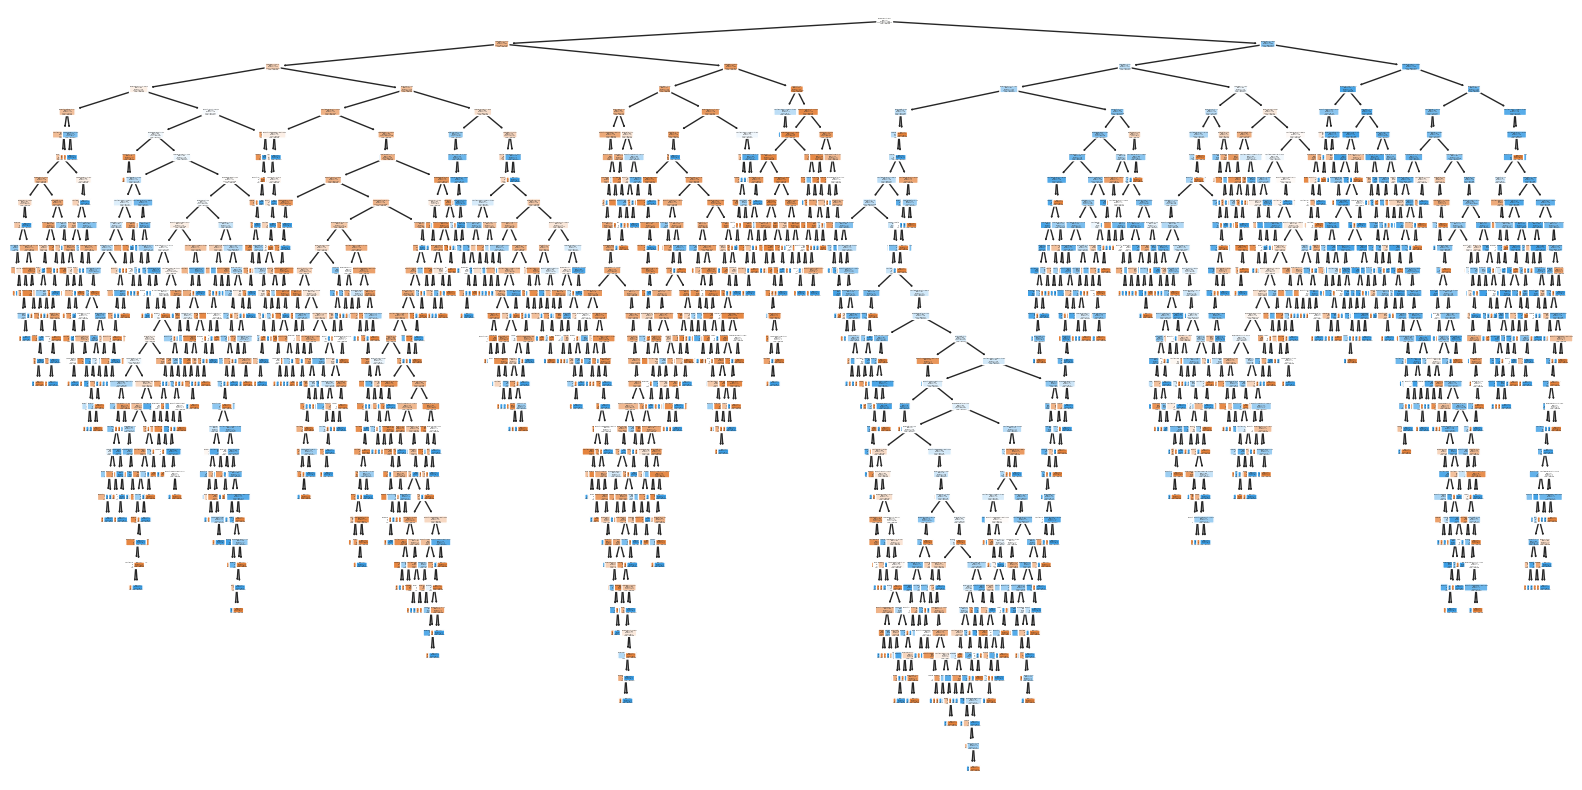

In [207]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, Y_train)
y_pred_dt = decision_tree.predict(X_test)
accuracy_dt = accuracy_score(Y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)

# Tree visualization
plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree, feature_names=X.columns, class_names=['Red Win', 'Blue Win'], filled=True, rounded=True)
plt.show()

In [208]:
def evaluate_model_cv(X, Y, clf, cv=10):

    # If X or Y are pandas objects, convert to numpy arrays
    if hasattr(X, 'values'):
        X_np = X.values
    else:
        X_np = X
    if hasattr(Y, 'values'):
        Y_np = Y.values
    else:
        Y_np = Y

    skf = StratifiedKFold(n_splits=cv)
    recalls = []
    specificities = []

    for train_index, test_index in skf.split(X_np, Y_np):
        X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
        y_train_fold, y_test_fold = Y_np[train_index], Y_np[test_index]

        clf.fit(X_train_fold, y_train_fold)
        y_pred = clf.predict(X_test_fold)

        tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        recalls.append(recall)
        specificities.append(specificity)

    sens_mean = np.mean(recalls)
    sens_std = np.std(recalls)
    spec_mean = np.mean(specificities)
    spec_std = np.std(specificities)

    print(f"Recall:     {sens_mean:.4f} ± {sens_std:.4f}")
    print(f"Specificity: {spec_mean:.4f} ± {spec_std:.4f}")

In [209]:
accuracies = []
depths = range(1, 11)
for x in depths:
    decision_tree = DecisionTreeClassifier(max_depth=x, random_state=0)
    decision_tree.fit(X_train, Y_train)
    y_pred_dt = decision_tree.predict(X_test)
    accuracy_dt = accuracy_score(Y_test, y_pred_dt)
    accuracies.append(accuracy_dt)
    print(f"Decision Tree Accuracy with max_depth={x}:", accuracy_dt)
    evaluate_model_cv(X, Y, decision_tree)

Decision Tree Accuracy with max_depth=1: 0.7327935222672065
Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy with max_depth=2: 0.7327935222672065
Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy with max_depth=3: 0.7327935222672065
Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy with max_depth=4: 0.725506072874494
Recall:     0.7049 ± 0.0372
Specificity: 0.7432 ± 0.0319
Decision Tree Accuracy with max_depth=5: 0.7133603238866397
Recall:     0.7002 ± 0.0268
Specificity: 0.7468 ± 0.0263
Decision Tree Accuracy with max_depth=6: 0.7113360323886639
Recall:     0.7012 ± 0.0304
Specificity: 0.7424 ± 0.0290
Decision Tree Accuracy with max_depth=7: 0.7101214574898785
Recall:     0.7041 ± 0.0390
Specificity: 0.7264 ± 0.0293
Decision Tree Accuracy with max_depth=8: 0.7024291497975709
Recall:     0.7020 ± 0.0255
Specificity: 0.7133 ± 0.0279
Decision Tree Accuracy with max_depth=9: 0.7093117408906883
Recal

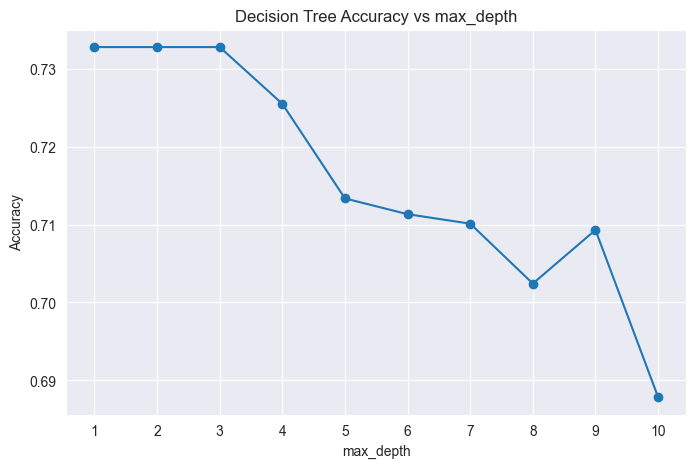

In [210]:
plt.figure(figsize=(8, 5))
plt.plot(depths, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs max_depth')
plt.xticks(depths)
plt.grid(True)
plt.show()

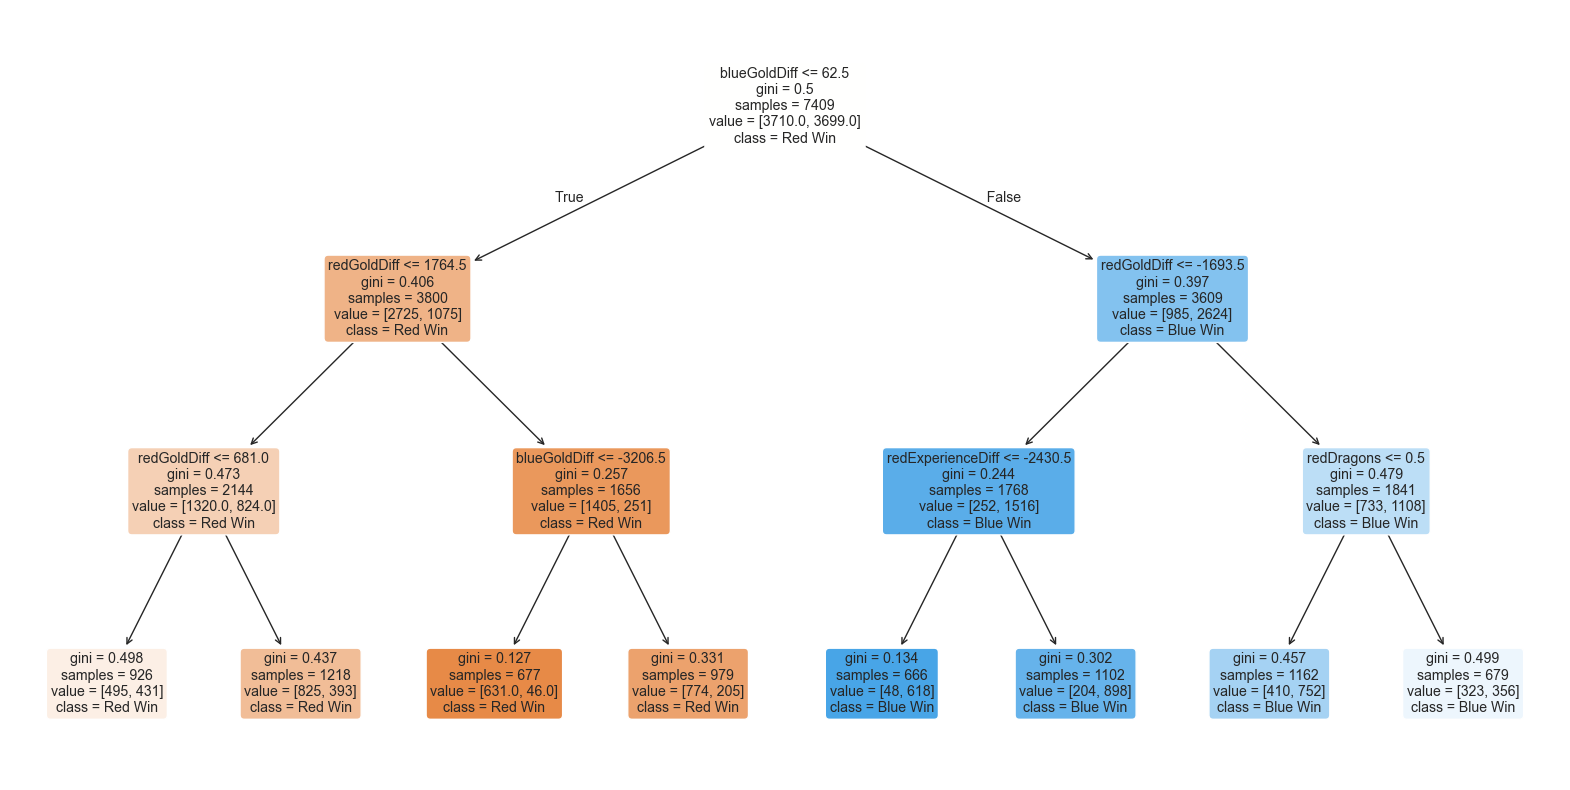

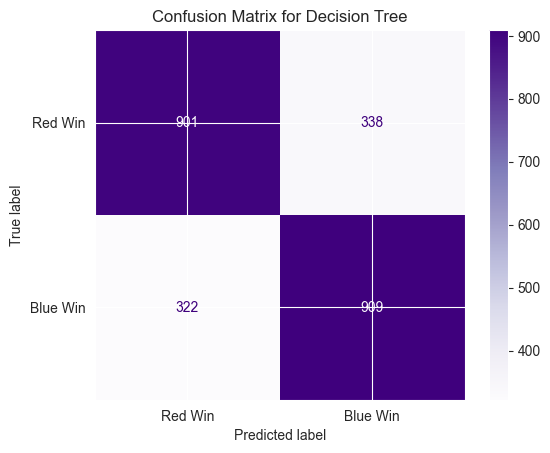

Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy with max_depth=3: 0.7327935222672065


In [211]:
# Decision Tree with max_depth=3
dt_new = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_new.fit(X_train, Y_train)
y_pred_dt = dt_new.predict(X_test)
accuracy_dt = accuracy_score(Y_test, y_pred_dt)

# Tree visualization with max_depth=3
plt.figure(figsize=(20,10))
tree.plot_tree(dt_new, feature_names=X.columns, class_names=['Red Win', 'Blue Win'], filled=True, rounded=True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

evaluate_model_cv(X, Y, dt_new, cv=10) 
print("Decision Tree Accuracy with max_depth=3:", accuracy_dt)

Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy on cleaned data: 0.7327935222672065


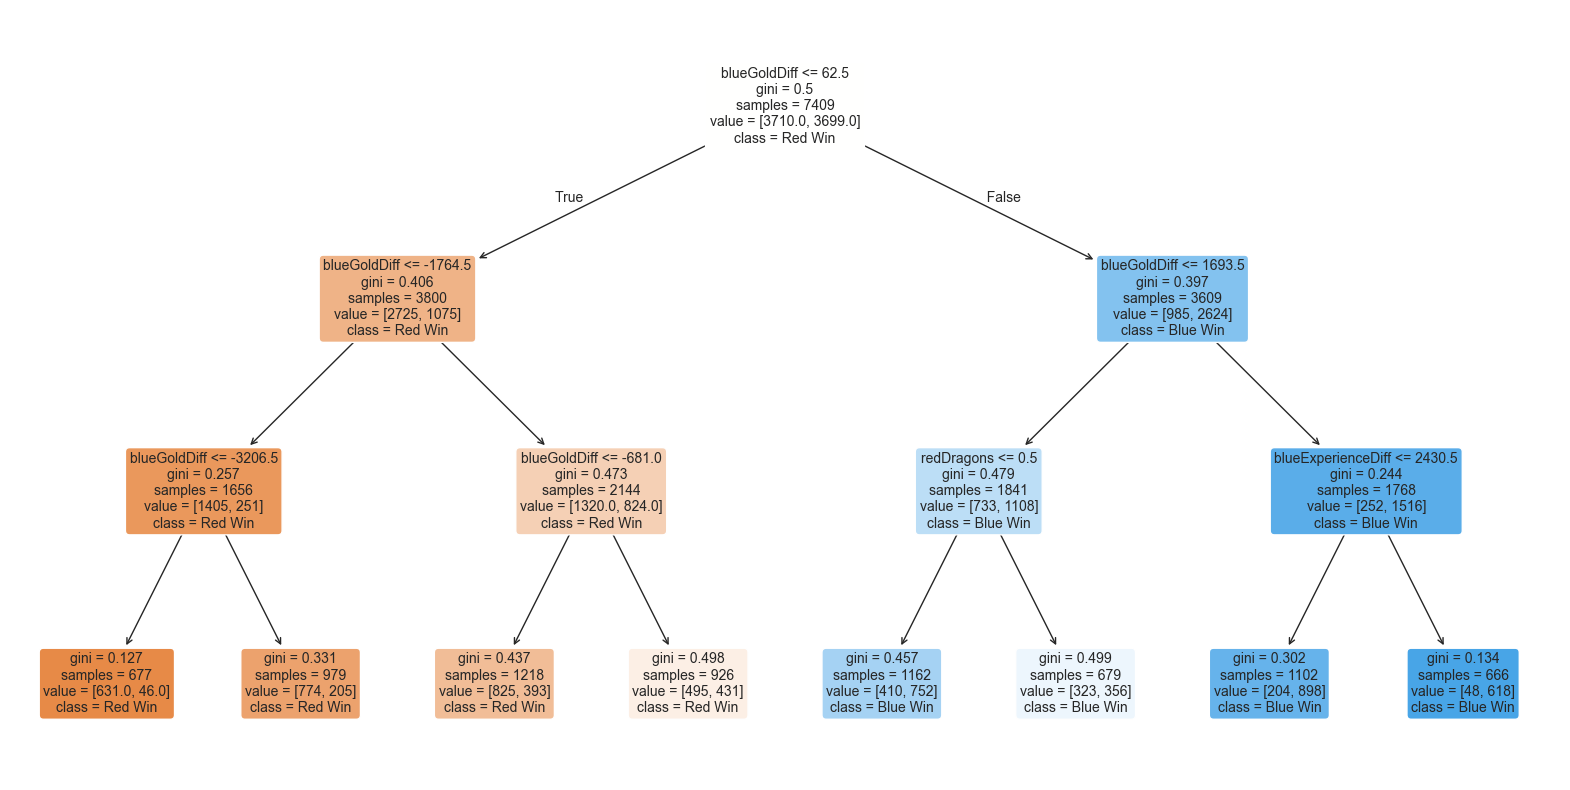

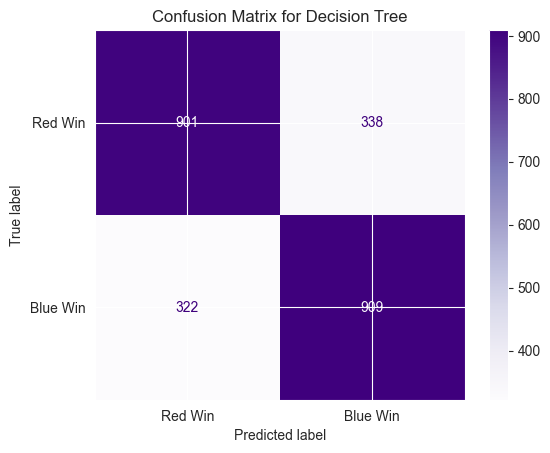

In [220]:
# Cleaned data
decision_tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
decision_tree.fit(X_train_clean, Y_train_clean)
y_pred_dt = decision_tree.predict(X_test_clean)
accuracy_dt = accuracy_score(Y_test_clean, y_pred_dt)
evaluate_model_cv(X_clean, Y_clean, dt_new, cv=10) 
print("Decision Tree Accuracy on cleaned data:", accuracy_dt)

plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree, feature_names=X_train_clean.columns, class_names=['Red Win', 'Blue Win'], filled=True, rounded=True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(Y_test_clean, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

Recall:     0.6923 ± 0.0157
Specificity: 0.7565 ± 0.0172
Decision Tree Accuracy on engineered data: 0.7327935222672065


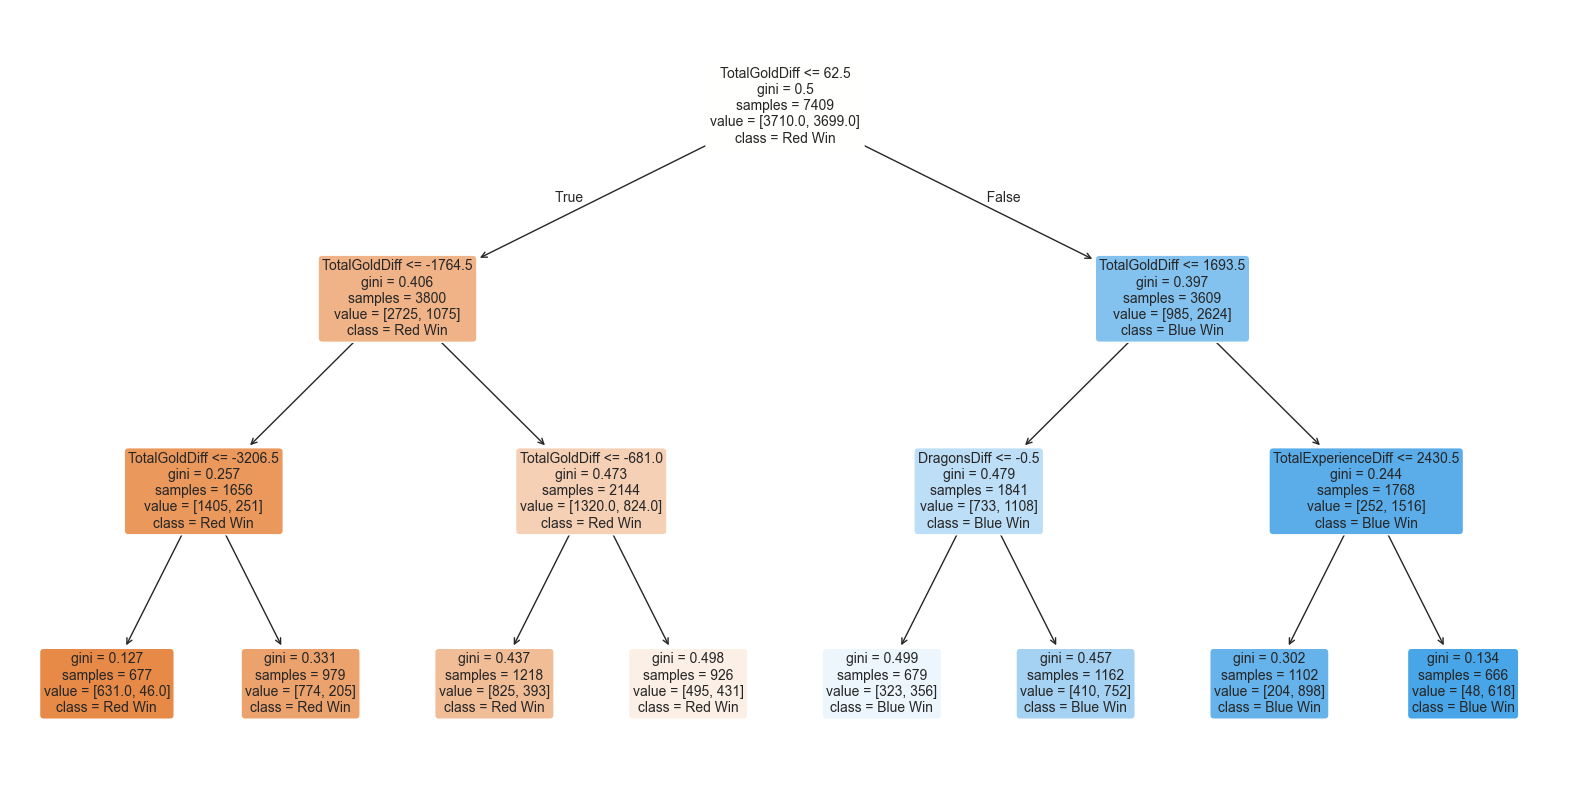

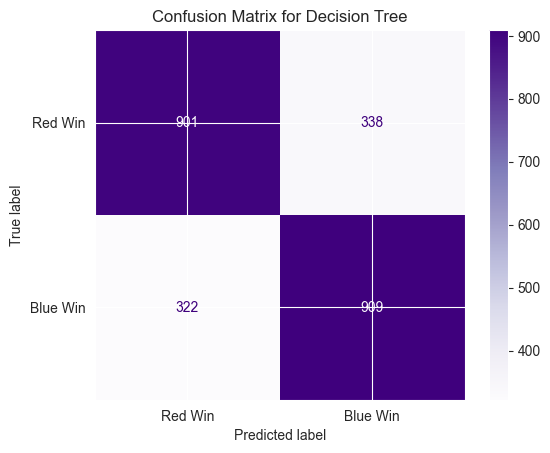

In [221]:
# Engineered features
decision_tree = DecisionTreeClassifier(max_depth = 3, random_state=0)
decision_tree.fit(X_train_fe, Y_train_fe)
y_pred_dt = decision_tree.predict(X_test_fe)
accuracy_dt = accuracy_score(Y_test_fe, y_pred_dt)
evaluate_model_cv(X_fe, Y_fe, dt_new, cv=10) 
print("Decision Tree Accuracy on engineered data:", accuracy_dt)

plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree, feature_names=X_train_fe.columns, class_names=['Red Win', 'Blue Win'], filled=True, rounded=True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(Y_test_fe, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

##### 🔝 XGBoost Classifier 🔝

In [214]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 10, 20]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


c:\Users\stefa\sem6\lol-data-analysis\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Recall:     0.7256 ± 0.0166
Specificity: 0.7357 ± 0.0188
XGBoost Accuracy: 0.742914979757085


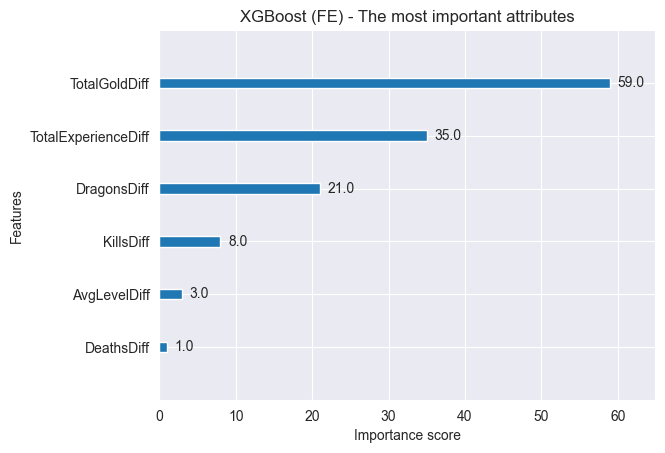

In [219]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.06, max_depth=4, subsample=0.4, colsample_bytree=0.8, gamma=20, random_state=0)
evaluate_model_cv(X, Y, xgb_clf)

xgb_clf.fit(X_fe, Y_fe, 
            eval_set=[(X_test_fe, Y_test_fe)],
            verbose=False)

# Prediction and result
y_pred_xgb = xgb_clf.predict(X_test_fe)
accuracy_xgb = accuracy_score(Y_test_fe, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

xgb.plot_importance(xgb_clf, max_num_features=10)
plt.title("XGBoost (FE) - The most important attributes")
plt.show()